In [295]:
# Import SQLAlchemy's declarative_base module, based upon which new classes are created
from sqlalchemy.ext.declarative import declarative_base

# Create an engine, which enables Python to communicate with SQL
from sqlalchemy import create_engine

# Modules necessary to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, VARCHAR

from sqlalchemy.orm import Session

from sqlalchemy.ext.automap import automap_base

from sqlalchemy import func, extract, DateTime
from datetime import datetime, timedelta

import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import numpy as py
import csv
import os

In [296]:
# The database file we create will be called hawaii.sqlite
engine = create_engine('sqlite:///hawaii.sqlite')

In [297]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [298]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [299]:
Base.classes.keys()

['hawaii_measurement', 'hawaii_measurements', 'hawaii_stations']

In [300]:
hi_measurement = Base.classes.hawaii_measurement
hi_stations = Base.classes.hawaii_stations

In [301]:
#Create a session
session = Session(engine)

In [302]:
# Use a session query to find the first row in the database
data = session.query(hi_measurement).first()
data.__dict__

{'DATE': '2010-01-01',
 'PRCP': 0.08,
 'STATION': 'USC00519397',
 'TOBS': 65.0,
 '_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20745967358>,
 'id': 1}

# Precipitation Analysis

In [303]:
#find the year with the most precipitation
years_of_prcp = session.query(extract('year', hi_measurement.DATE), func.count(hi_measurement.PRCP)).\
    filter(hi_measurement.PRCP != "0.0").\
    group_by(extract('year', hi_measurement.DATE)).\
    order_by(func.count(hi_measurement.PRCP).desc()).\
    all()

In [304]:
#2011 has the mos precipitation data
years_of_prcp

[(2011, 1487),
 (2010, 1451),
 (2014, 1384),
 (2015, 1268),
 (2016, 1267),
 (2013, 1238),
 (2012, 1201),
 (2017, 622)]

In [305]:
#precipitation data
prcp_data = session.query(hi_measurement.DATE, hi_measurement.PRCP).\
    distinct(hi_measurement.DATE, hi_measurement.PRCP).\
    filter(hi_measurement.PRCP != 0).\
    filter(extract('year', hi_measurement.DATE) == 2011).\
    order_by(hi_measurement.DATE.desc()).\
    all()
prcp_data

[('2011-12-31', 0.01),
 ('2011-12-31', 0.04),
 ('2011-12-31', 0.08),
 ('2011-12-31', 0.1),
 ('2011-12-31', 0.25),
 ('2011-12-30', 0.02),
 ('2011-12-30', 0.01),
 ('2011-12-30', 0.05),
 ('2011-12-29', 0.01),
 ('2011-12-28', 0.03),
 ('2011-12-28', 0.02),
 ('2011-12-28', 0.06),
 ('2011-12-27', 0.03),
 ('2011-12-27', 0.04),
 ('2011-12-27', 0.05),
 ('2011-12-27', 0.06),
 ('2011-12-26', 0.05),
 ('2011-12-25', 0.03),
 ('2011-12-25', 0.05),
 ('2011-12-25', 0.07),
 ('2011-12-25', 0.04),
 ('2011-12-25', 0.58),
 ('2011-12-24', 0.1),
 ('2011-12-24', 0.02),
 ('2011-12-24', 0.11),
 ('2011-12-24', 0.01),
 ('2011-12-24', 0.8),
 ('2011-12-23', 0.04),
 ('2011-12-23', 0.02),
 ('2011-12-23', 0.01),
 ('2011-12-23', 0.12),
 ('2011-12-23', 0.42),
 ('2011-12-22', 0.03),
 ('2011-12-22', 0.06),
 ('2011-12-22', 0.12),
 ('2011-12-22', 0.02),
 ('2011-12-22', 0.11),
 ('2011-12-22', 0.27),
 ('2011-12-21', 0.18),
 ('2011-12-21', 0.24),
 ('2011-12-21', 0.25),
 ('2011-12-21', 0.19),
 ('2011-12-21', 0.58),
 ('2011-12-21'

In [306]:
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.set_index(["DATE"])
prcp_data_df.head()

,DATE,PRCP
0,2011-12-31,0.01
1,2011-12-31,0.04
2,2011-12-31,0.08
3,2011-12-31,0.10
4,2011-12-31,0.25


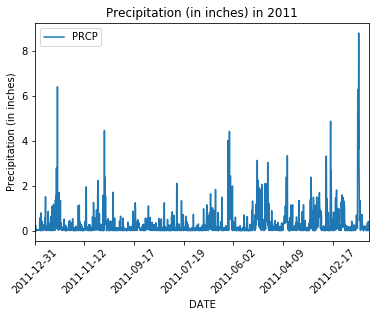

In [307]:
#create a plot for precipitation 
prcp_data_df.time = pd.to_datetime(prcp_data_df["DATE"], format='%Y-%m-%d %H:%M:%S.%f')
prcp_data_df.set_index(prcp_data_df["DATE"],  prcp_data_df["PRCP"], inplace=True)
prcp_data_df.plot()
plt.title("Precipitation (in inches) in 2011")
plt.ylabel("Precipitation (in inches)")
plt.xticks(rotation=45)
plt.show()

In [308]:
#define the aggregation calculations
aggregations = {
    'PRCP' : {
        'num_records' : 'count',
        'average' : 'mean',
        'median' : 'median',
        'standard_deviation' : 'std',
        'sum' : 'sum' } }
prcp_data_df.agg(aggregations)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  if __name__ == '__main__':


,PRCP
num_records,1348.000000
average,0.306847
median,0.100000
standard_deviation,0.639292
sum,413.630000


# Station Analysis

In [309]:
#Count the number of stations
num_stations = session.query(func.count(hi_stations.STATION.distinct())).scalar()
print("Number Of Stations: " + str(num_stations))

Number Of Stations: 9


In [310]:
#list the stations and their observation counts
observations_per_station = session.query(hi_measurement.STATION, func.count(hi_measurement.PRCP)).\
    group_by(hi_measurement.STATION).\
    order_by(func.count(hi_measurement.STATION).desc()).\
    all()
observations_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [311]:
station = str(observations_per_station[0][0])
station

'USC00519281'

In [312]:
#get the most recent tobs based on the station 'USC00519281'
most_recent_tobs = session.query(hi_measurement.DATE).\
    filter(hi_measurement.STATION == station).\
    filter(hi_measurement.TOBS != 0).\
    group_by(hi_measurement.STATION).\
    order_by(func.count(hi_measurement.DATE).desc()).\
    all()[0][0]
most_recent_tobs

'2017-08-18'

In [313]:
#find the end date from first non zero observation for tobs at given station
#assuming each month is 4 weeks, 4 weeks * 12 months = 48
end_date = (datetime.strptime(most_recent_tobs , '%Y-%m-%d') - timedelta(weeks=48)).\
    strftime('%Y-%m-%d') #converts datetime to string
end_date

'2016-09-16'

In [314]:
#last 12 months of temperature observation (tobs)
#year_of_tobs = session.query(extract('year', hi_measurement.DATE).label("Year"), extract('month', hi_measurement.DATE).label("Month"), func.avg(hi_measurement.TOBS).label("Average_TOBS")).\
year_of_tobs = session.query(extract('year', hi_measurement.DATE).label("Year"), extract('month', hi_measurement.DATE).label("Month"), hi_measurement.TOBS).\
    filter(hi_measurement.STATION == 'USC00519281').\
    filter(hi_measurement.DATE <= most_recent_tobs).\
    filter(hi_measurement.DATE >= end_date).\
    order_by(extract('year', hi_measurement.DATE).asc(),extract('month', hi_measurement.DATE)).\
    all()
    #group_by(extract('month', hi_measurement.DATE)).\
    
year_of_tobs

[(2016, 9, 78.0),
 (2016, 9, 79.0),
 (2016, 9, 78.0),
 (2016, 9, 78.0),
 (2016, 9, 76.0),
 (2016, 9, 74.0),
 (2016, 9, 77.0),
 (2016, 9, 78.0),
 (2016, 9, 79.0),
 (2016, 9, 79.0),
 (2016, 9, 77.0),
 (2016, 9, 80.0),
 (2016, 9, 78.0),
 (2016, 9, 78.0),
 (2016, 9, 78.0),
 (2016, 10, 77.0),
 (2016, 10, 79.0),
 (2016, 10, 79.0),
 (2016, 10, 79.0),
 (2016, 10, 79.0),
 (2016, 10, 75.0),
 (2016, 10, 76.0),
 (2016, 10, 73.0),
 (2016, 10, 72.0),
 (2016, 10, 71.0),
 (2016, 10, 77.0),
 (2016, 10, 79.0),
 (2016, 10, 78.0),
 (2016, 10, 79.0),
 (2016, 10, 77.0),
 (2016, 10, 79.0),
 (2016, 10, 77.0),
 (2016, 10, 78.0),
 (2016, 10, 78.0),
 (2016, 10, 78.0),
 (2016, 10, 78.0),
 (2016, 10, 77.0),
 (2016, 10, 74.0),
 (2016, 10, 75.0),
 (2016, 10, 76.0),
 (2016, 10, 73.0),
 (2016, 10, 76.0),
 (2016, 10, 74.0),
 (2016, 10, 77.0),
 (2016, 10, 76.0),
 (2016, 10, 76.0),
 (2016, 11, 74.0),
 (2016, 11, 75.0),
 (2016, 11, 75.0),
 (2016, 11, 75.0),
 (2016, 11, 75.0),
 (2016, 11, 71.0),
 (2016, 11, 63.0),
 (2016, 

In [315]:
year_of_tobs_df = pd.DataFrame(year_of_tobs, columns=["Year", "Month", "Average_TOBS"])
year_of_tobs_df.set_index("Month")
year_of_tobs_df.head()

,Year,Month,Average_TOBS
0,2016,9,78.0
1,2016,9,79.0
2,2016,9,78.0
3,2016,9,78.0
4,2016,9,76.0


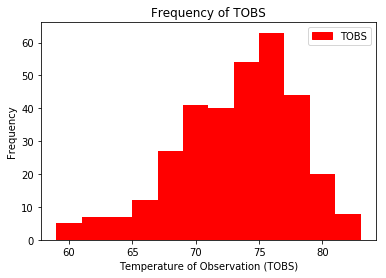

In [316]:
fig, ax0 = plt.subplots()
red_patch = mpatches.Patch(color='red', label="TOBS")
_ = plt.hist(year_of_tobs_df["Average_TOBS"], bins=12, color='red')
_ = plt.xlabel('Temperature of Observation (TOBS)')
_ = plt.ylabel("Frequency")
_ = plt.title("Frequency of TOBS")
_ = plt.legend(handles=[red_patch])
#year_of_tobs_df[["Months"]].plot.hist(bins=12, alpha=0.5, histtype='bar')
plt.show()

# Temperature Analysis

In [317]:
#function to calculate the min, mean and max TOBS given a start and end date
def calc_temps(start_date, end_date):
    return session.query(func.min(hi_measurement.TOBS).label("Min"), 
                               func.max(hi_measurement.TOBS).label("Max"),
                               func.avg(hi_measurement.TOBS).label("Avg")).\
    filter(hi_measurement.DATE >= start_date).\
    filter(hi_measurement.DATE <= end_date).\
    all()

In [318]:
print(calc_temps('2010-01-01', '2012-01-01')[0])

(56.0, 87.0, 72.5791093410572)


In [319]:
results = calc_temps('2010-01-01', '2012-01-01')[0]
error = results[0:2]
data = results[2]
error

(56.0, 87.0)

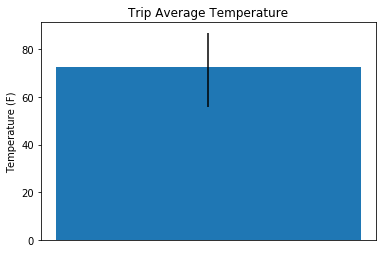

In [320]:
plt.bar(0, data, width=1, yerr=[[data - error[0]], [error[1] - data]])
plt.title("Trip Average Temperature")
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.show()

# Climate App

In [456]:
from flask import Flask, jsonify, request
from urllib.parse import urlparse

In [457]:
# 2. Create an app, being sure to pass __name__
app = Flask(__name__)

In [372]:
#query the dates and precipitation observations from the last year
@app.route("/api/v1.0/precipitation")
def precipitation():
    prcp_data = session.query(hi_measurement.DATE.label("Date"), hi_measurement.PRCP.label("PRCP")).\
        filter(hi_measurement.DATE <= most_recent_tobs).\
        filter(hi_measurement.DATE >= end_date).\
        order_by(extract('year', hi_measurement.DATE).asc(),extract('month', hi_measurement.DATE)).\
        all()
    prcp_data_dict = dict((k, v) for k, v in prcp_data)
    print(data_dict)
    return jsonify(data_dict)

In [373]:
#Return a json list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    return jsonify(session.query(hi_stations.STATION.distinct()).all())

In [374]:
#Return a json list of Temperature Observations (tobs) for the previous year
@app.route("/api/v1.0/tobs")
def tobs():
    tobs_data = session.query(hi_measurement.TOBS.label("TOBS")).\
        filter(hi_measurement.DATE <= most_recent_tobs).\
        filter(hi_measurement.DATE >= end_date).\
        order_by(extract('year', hi_measurement.DATE).asc(),extract('month', hi_measurement.DATE)).\
        all()
    return jsonify(tobs_data)

In [458]:
#Return a json list of the min, average, max temperature for a given start or start-end range.
@app.route("/api/v1.0/", methods=['GET', 'POST'])
def show_stats():
    _start_date = request.args.get('start_date')
    _end_date = request.args.get('end_date')
    
    if _end_date == None: 
        data_range = session.query(func.min(hi_measurement.TOBS).label("Min"), 
                                   func.max(hi_measurement.TOBS).label("Max"),
                                   func.avg(hi_measurement.TOBS).label("Avg")).\
        filter(hi_measurement.DATE >= _start_date).\
        all()
    else:
        data_range = session.query(func.min(hi_measurement.TOBS).label("Min"), 
                                   func.max(hi_measurement.TOBS).label("Max"),
                                   func.avg(hi_measurement.TOBS).label("Avg")).\
        filter(hi_measurement.DATE >= _start_date).\
        filter(hi_measurement.DATE <= _end_date).\
        all()
    print(_start_date)
    print(_end_date)
    print(data_range)
    return jsonify(data_range)

In [459]:
if __name__ == "__main__":
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Oct/2017 12:42:22] "GET /api/v1.0/?start_date=2010-09-16 HTTP/1.1" 200 -


2010-09-16
None
[(53.0, 87.0, 73.18409994321408)]


127.0.0.1 - - [23/Oct/2017 12:42:34] "GET /api/v1.0/?start_date=2010-09-16&end_date=2012-02-18 HTTP/1.1" 200 -


2010-09-16
2012-02-18
[(56.0, 87.0, 72.37348484848485)]


127.0.0.1 - - [23/Oct/2017 12:42:55] "GET /api/v1.0/?start_date=2010-09-16&end_date=2017-02-18 HTTP/1.1" 200 -


2010-09-16
2017-02-18
[(53.0, 87.0, 73.03964891041163)]


127.0.0.1 - - [23/Oct/2017 12:44:34] "GET /api/v1.0/?start_date=2016-01-01&end_date=2017-12-31 HTTP/1.1" 200 -


2016-01-01
2017-12-31
[(56.0, 87.0, 74.14409066378845)]


127.0.0.1 - - [23/Oct/2017 12:45:19] "GET /api/v1.0/?start_date=2010-01-01&end_date=2011-01-01 HTTP/1.1" 200 -


2010-01-01
2011-01-01
[(56.0, 87.0, 72.49480472948764)]


127.0.0.1 - - [23/Oct/2017 12:45:28] "GET /api/v1.0/?start_date=2010-01-01 HTTP/1.1" 200 -


2010-01-01
None
[(53.0, 87.0, 73.09795396419437)]
